In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm

from models import LeNet_BNN, LeNet_BNN_uni, LeNet
from utils import train_BNN, train_DNN, test_BNN, test_DNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dnn = LeNet()
dnn.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_temp_1.0_ep100_20240711-160323/best_model.pth'))

# MNIST dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

test_DNN(dnn, test_loader)


In [ ]:
# bnn_uni = LeNet_BNN_uni().to(device)
# bnn_uni.load_state_dict(torch.load('bnn_uni.pth'))
# # train_BNN(10, bnn_uni)
# test_BNN(bnn_uni, test_loader, 100, 1024, 'cuda')

### $\mu$, $\sigma$ 학습 가능한지 확인

In [ ]:
from torch.distributions import Normal
target_w = 3.0

# Sample the weights
mu = torch.nn.Parameter(torch.Tensor(1))
sigma = torch.nn.Parameter(torch.Tensor(1))
mu.data.normal_(0, 0.1)
sigma.data.normal_(1, 0.1)

w_dist = Normal(mu,sigma)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([mu, sigma], lr=0.01)

# Log for plotting
mu_log = []
sigma_log = []

# Sample the weights
for epoch in range(1000):
    w = w_dist.rsample()
    
    loss_val = loss(w, torch.Tensor([target_w]))
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.item())
    sigma_log.append(sigma.item())
    
import matplotlib.pyplot as plt

plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['mu', 'sigma'])

# plot target
plt.plot([0,1000], [target_w, target_w], 'r--')

### 신경망 모델의 가중치를 분포로 학습가능한지 확인 $w_i \sim \mathbf{N}(\mu_i,\sigma_i)$

In [ ]:

w_conv1_dnn = dnn.conv1.weight.data

# Sample the weights
mu = torch.nn.Parameter(torch.zeros_like(w_conv1_dnn))
sigma = torch.nn.Parameter(torch.ones_like(w_conv1_dnn))

w_dist = Normal(mu,sigma)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([mu, sigma], lr=0.01)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in tqdm(range(1000)):
    w = w_dist.rsample()
    
    loss_val = loss(w, w_conv1_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = mu  # 실제 mu_kernel 값으로 대체
rho_kernel = sigma  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv1.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(6,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

### 만약 입력 X까지 고려한 출력 y를 loss로 사용한다면?

In [ ]:
# bnn_uni = LeNet_BNN_uni().to(device)
# loss = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(bnn_uni.conv1.parameters(), lr=0.01)

# losses = []

# for e in range(10):
#     for x,y in tqdm(train_loader):
        
#         y_bnn, _ = bnn_uni.conv1.forward(x.to(device))
        
            
#         y_dnn = dnn.conv1.forward(x.to(device))

#         loss_val = loss(y_bnn, y_dnn)

#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()
        
#         losses.append(loss_val.item())
    


# plt.plot(losses)
# plt.grid()

# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# # 예시 데이터, 실제 데이터로 대체하세요.
# mu_kernel = bnn_uni.conv1.mu_kernel  # 실제 mu_kernel 값으로 대체
# rho_kernel = bnn_uni.conv1.rho_kernel  # 실제 rho_kernel 값으로 대체
# w_dnn = dnn.conv1.weight.data
# # sigma_weight 계산
# sigma_weight = torch.log1p(torch.exp(rho_kernel))

# plt.figure(figsize=(15,15))
# for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
#     print(w_target.shape, mu.shape, sigma.shape)
#     w_target = w_target.cpu().detach().numpy()
#     plt.subplot(6,1, idx+1)
#     for i in range(3):
        
#         for j in range(3):
            
#             plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
#             x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
#             pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
#             # plt.subplot(3,3,i+j+1)

#             plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

### Aleatoric?

In [ ]:
bnn_uni = LeNet_BNN_uni().to(device)

In [ ]:

w_conv1_dnn = dnn.conv1.weight.data

# Sample the weights

# loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([bnn_uni.conv1.mu_kernel, bnn_uni.conv1.rho_kernel], lr=1e-3)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in range(1000):
    
    mu = bnn_uni.conv1.mu_kernel
    sigma = torch.log1p(torch.exp(bnn_uni.conv1.rho_kernel))

    loss_val = 0.5 * torch.mean((mu - w_conv1_dnn)**2 / sigma + sigma )
        
        
    
    # loss_val = loss(w, w_conv1_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = bnn_uni.conv1.mu_kernel  # 실제 mu_kernel 값으로 대체
rho_kernel = bnn_uni.conv1.rho_kernel  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv1.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(6,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

In [ ]:

w_conv2_dnn = dnn.conv2.weight.data

# Sample the weights

# loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([bnn_uni.conv2.mu_kernel, bnn_uni.conv2.rho_kernel], lr=1e-3)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in range(1000):
    
    mu = bnn_uni.conv2.mu_kernel
    sigma = torch.log1p(torch.exp(bnn_uni.conv2.rho_kernel))

    loss_val = 0.5 * torch.mean((mu - w_conv2_dnn)**2 / sigma + sigma )
        
        
    
    # loss_val = loss(w, w_conv2_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = bnn_uni.conv2.mu_kernel  # 실제 mu_kernel 값으로 대체
print(mu_kernel.shape)
rho_kernel = bnn_uni.conv2.rho_kernel  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv2.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(16,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

### Set the Prior distribution 

In [ ]:
bnn_new = LeNet_BNN_uni().to(device)

In [ ]:
bnn_new.conv1.prior_mean, bnn_new.conv1.prior_variance, bnn_new.conv2.prior_mean, bnn_new.conv2.prior_variance

In [ ]:
# bnn_new.conv1.prior_mean = bnn_uni.conv1.mu_kernel.detach().clone()
# bnn_new.conv1.prior_variance = torch.log1p(torch.exp(bnn_uni.conv1.rho_kernel)).detach().clone()

# bnn_new.conv2.prior_mean = bnn_uni.conv2.mu_kernel.detach().clone()
# bnn_new.conv2.prior_variance = torch.log1p(torch.exp(bnn_uni.conv2.rho_kernel)).detach().clone()

In [ ]:
bnn_new.conv1.prior_weight_mu = bnn_uni.conv1.mu_kernel.detach().clone()
bnn_new.conv1.prior_weight_sigma = torch.log1p(torch.exp(bnn_uni.conv1.rho_kernel)).detach().clone()

bnn_new.conv2.prior_weight_mu = bnn_uni.conv2.mu_kernel.detach().clone()
bnn_new.conv2.prior_weight_sigma = torch.log1p(torch.exp(bnn_uni.conv2.rho_kernel)).detach().clone()

In [ ]:
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
# class args:
#     pass
# args = args()
# args.t = 1.0
# writer = SummaryWriter(f'runs/bnn_new2')
# train_BNN(epoch= 100, model = bnn_new, train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_new.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args)

### MOPED

In [ ]:
# from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
# from torch.utils.tensorboard import SummaryWriter
# bnn_rho_init = -3.0
# moped_delta_factor = 0.2
# const_bnn_prior_parameters = {
#         "prior_mu": 0.0,
#         "prior_sigma": 1.0,
#         "posterior_mu_init": 0.0,
#         "posterior_rho_init": bnn_rho_init,
#         "type": "Reparameterization",  # Flipout or Reparameterization
#         "moped_enable": True,  # initialize mu/sigma from the dnn weights
#         "moped_delta": moped_delta_factor,
#     }


# dnn_moped = LeNet()
# dnn_moped.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_temp_1.0_ep100_20240711-160323/best_model.pth'))

# dnn_to_bnn(dnn_moped, const_bnn_prior_parameters)

# class args:
#     pass

# args = args()
# args.t = 1.0
# writer = SummaryWriter(f'runs/dnn_moped2')
# train_BNN(epoch= 100, model = dnn_moped.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(dnn_moped.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=True)



### multivariate Gaussian distribution

### covariance matrix 학습 가능한지 확인

In [ ]:
target_matrix = torch.eye(10, requires_grad=True)

L_init = torch.tril(torch.rand(10,10))
L = nn.Parameter(L_init)

optimizer = optim.Adam([L], lr=1e-2)

losses = []
for epoch in range(1000):
    
    loss = 0.5 * torch.sum((L.T @ L - target_matrix)**2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
plt.plot(losses)
plt.grid()


In [ ]:
plt.imshow((L.T@L).detach().numpy())

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)

import copy
cov_not_optimized = bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()  
print(cov_not_optimized.shape)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv1.L_param], lr=1e-2)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    c_in, c_out, k, _ = w_conv1_dnn.size()
    
    mu = bnn_multi.conv1.mu_kernel
    mu_flat = mu.view(-1)
    w_flat = w_conv1_dnn.view(-1)

    epslion = 1e-6
    cov = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
    
    # Sampling the weight
    w = torch.distributions.MultivariateNormal(mu_flat, cov).rsample().reshape(c_in, c_out, k, k)
    
    # k_value = torch.tensor(k, dtype=torch.float32).to(device)
    # pi_value = torch.tensor(torch.pi, dtype=torch.float32).to(device)
    # nnl = 0.5 * (k_value * torch.log(2 * pi_value) + torch.logdet(cov) + (w_flat - mu_flat).t() @ torch.inverse(cov) @ (w_flat - mu_flat))

    nnl = (w - w_conv1_dnn).pow(2).mean()
    optimizer.zero_grad()
    nnl.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nnl.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cov_not_optimized[:9,:9])
plt.title('Covariance matrix (not optimized)')

plt.subplot(1,3,2)
i=1
plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
plt.title('Covariance matrix (optimized)')
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
)

w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn = dnn.conv1.weight.data.view(-1)

# Visualize the difference using vertical lines
plt.figure(figsize=(10, 5))
x = range(len(w_dnn.cpu().detach().numpy()))

# # Plot DNN weights with thicker lines
# plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # Plot BNN weights with thinner lines
# plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# Plot differences

plt.vlines(x, ymin=0, ymax=(w_dnn.cpu().detach() - w_bnn.cpu().detach()).abs(), color='g', linewidth=1, label='DNN - BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Learned)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (abs)')
plt.ylim(0,3)
plt.show()


## Cov randomly initialized

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)

import copy
cov_not_optimized = bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()  
print(cov_not_optimized.shape)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel], lr=1e-2)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    c_in, c_out, k, _ = w_conv1_dnn.size()
    
    mu = bnn_multi.conv1.mu_kernel
    mu_flat = mu.view(-1)
    w_flat = w_conv1_dnn.view(-1)

    epslion = 1e-6
    cov = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
    
    # Sampling the weight
    w = torch.distributions.MultivariateNormal(mu_flat, cov).rsample().reshape(c_in, c_out, k, k)
    
    # k_value = torch.tensor(k, dtype=torch.float32).to(device)
    # pi_value = torch.tensor(torch.pi, dtype=torch.float32).to(device)
    # nnl = 0.5 * (k_value * torch.log(2 * pi_value) + torch.logdet(cov) + (w_flat - mu_flat).t() @ torch.inverse(cov) @ (w_flat - mu_flat))

    nnl = (w - w_conv1_dnn).pow(2).mean()
    optimizer.zero_grad()
    nnl.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nnl.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cov_not_optimized[:9,:9])
plt.title('Covariance matrix (not optimized)')

plt.subplot(1,3,2)
i=1
plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
plt.title('Covariance matrix (optimized)')
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
)

w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn = dnn.conv1.weight.data.view(-1)

# Visualize the difference using vertical lines
plt.figure(figsize=(10, 5))
x = range(len(w_dnn.cpu().detach().numpy()))

# # Plot DNN weights with thicker lines
# plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # Plot BNN weights with thinner lines
# plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# Plot differences

plt.vlines(x, ymin=0, ymax=(w_dnn.cpu().detach() - w_bnn.cpu().detach()).abs(), color='r', linewidth=1, label='DNN - BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Randomly Initialized)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (abs)')
plt.ylim(0,3)
plt.show()


# cov = I

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)

import copy
cov_not_optimized = bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()  
print(cov_not_optimized.shape)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv1.L_param], lr=1e-2)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    c_in, c_out, k, _ = w_conv1_dnn.size()
    
    mu = bnn_multi.conv1.mu_kernel
    mu_flat = mu.view(-1)
    w_flat = w_conv1_dnn.view(-1)

    epslion = 1e-6
    cov = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
    
    # Sampling the weight
    w = torch.distributions.MultivariateNormal(mu_flat, torch.eye(c_in * c_out * k * k).to(device)).rsample().reshape(c_in, c_out, k, k)
    
    # k_value = torch.tensor(k, dtype=torch.float32).to(device)
    # pi_value = torch.tensor(torch.pi, dtype=torch.float32).to(device)
    # nnl = 0.5 * (k_value * torch.log(2 * pi_value) + torch.logdet(cov) + (w_flat - mu_flat).t() @ torch.inverse(cov) @ (w_flat - mu_flat))

    nnl = (w - w_conv1_dnn).pow(2).mean()
    optimizer.zero_grad()
    nnl.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nnl.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cov_not_optimized[:9,:9])
plt.title('Covariance matrix (not optimized)')

plt.subplot(1,3,2)
i=1
plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
plt.title('Covariance matrix (optimized)')
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    torch.eye(c_in * c_out * k * k).to(device)
)

w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn = dnn.conv1.weight.data.view(-1)

# Visualize the difference using vertical lines
plt.figure(figsize=(10, 5))
x = range(len(w_dnn.cpu().detach().numpy()))

# # Plot DNN weights with thicker lines
# plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # Plot BNN weights with thinner lines
# plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.vlines(x, ymin=0, ymax=(w_bnn - w_dnn).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')
plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Cov = I)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)
plt.show()


In [ ]:
# import torch
# import matplotlib.pyplot as plt

# bnn_multi_not_trained = LeNet_BNN().to(device)

# # Sample the weights
# weight_dist = torch.distributions.MultivariateNormal(
#     bnn_multi_not_trained.conv1.mu_kernel.view(-1),
#     bnn_multi_not_trained.conv1.get_covariance_matrix()
# )

# w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
# w_dnn = dnn.conv1.weight.data.view(-1)

# # Visualize the difference using vertical lines
# plt.figure(figsize=(10, 5))
# x = range(len(w_dnn.cpu().detach().numpy()))

# # # Plot DNN weights with thicker lines
# # plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # # Plot BNN weights with thinner lines
# # plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# # Plot differences
# plt.vlines(x, ymin=0, ymax=(w_bnn - w_dnn).cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# plt.legend()
# plt.grid()
# plt.title('DNN and BNN Weight Differences')
# plt.xlabel('Weight Index')
# plt.ylabel('Weight Value')
# plt.show()


### Layer 2개 일 때는 어떻게 될까?

### Leanred

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() +  epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    bnn_multi.conv2.get_covariance_matrix() +  epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



### cov = I

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



### Cov randomly initialized

10000it [00:51, 195.04it/s]


Text(0.5, 1.0, 'Loss')

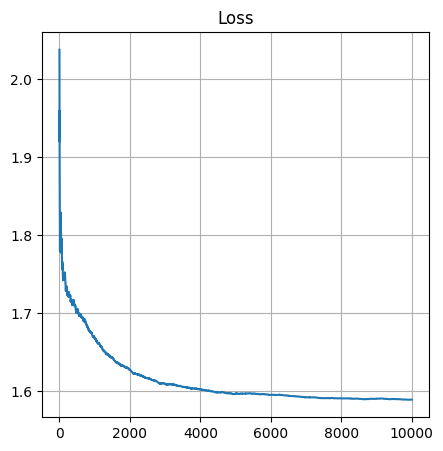

In [15]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv2.mu_kernel], lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix()
    cov_2 = bnn_multi.conv2.get_covariance_matrix()
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_bnn_conv1.mean().item() + mu_bnn_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


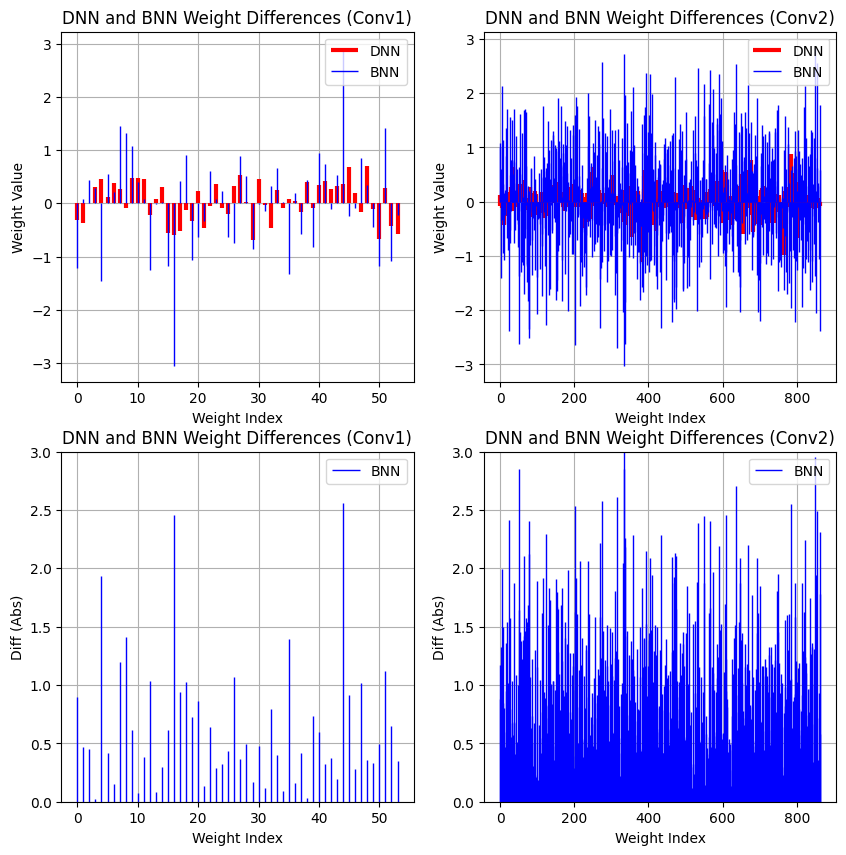

In [16]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() +  epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    bnn_multi.conv2.get_covariance_matrix() +  epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



### Set the Prior distribution using the learned covariance matrix

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm

from models import LeNet_BNN, LeNet_BNN_uni, LeNet
from utils import train_BNN, train_DNN, test_BNN, test_DNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dnn = LeNet()
dnn.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_temp_1.0_ep100_20240711-160323/best_model.pth'))

# MNIST dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

test_DNN(dnn, test_loader)


(0.9848, 0.046528087556362153)

In [2]:
dnn = LeNet().to(device)
dnn.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_ep100_20240710-202543/best_model.pth'))

test_DNN(dnn, test_loader)

(0.9853, 0.04415414296090603)

10000it [01:08, 146.61it/s]


Text(0.5, 1.0, 'Loss')

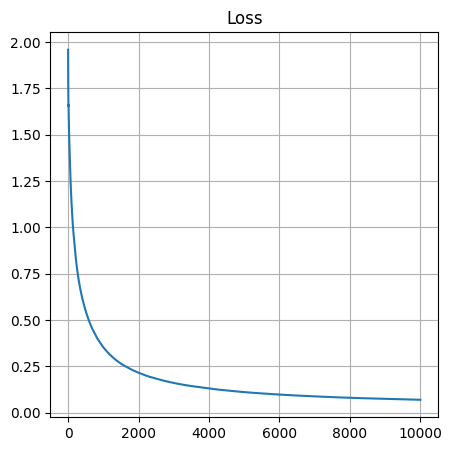

In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_flat_conv1.mean().item() + mu_flat_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


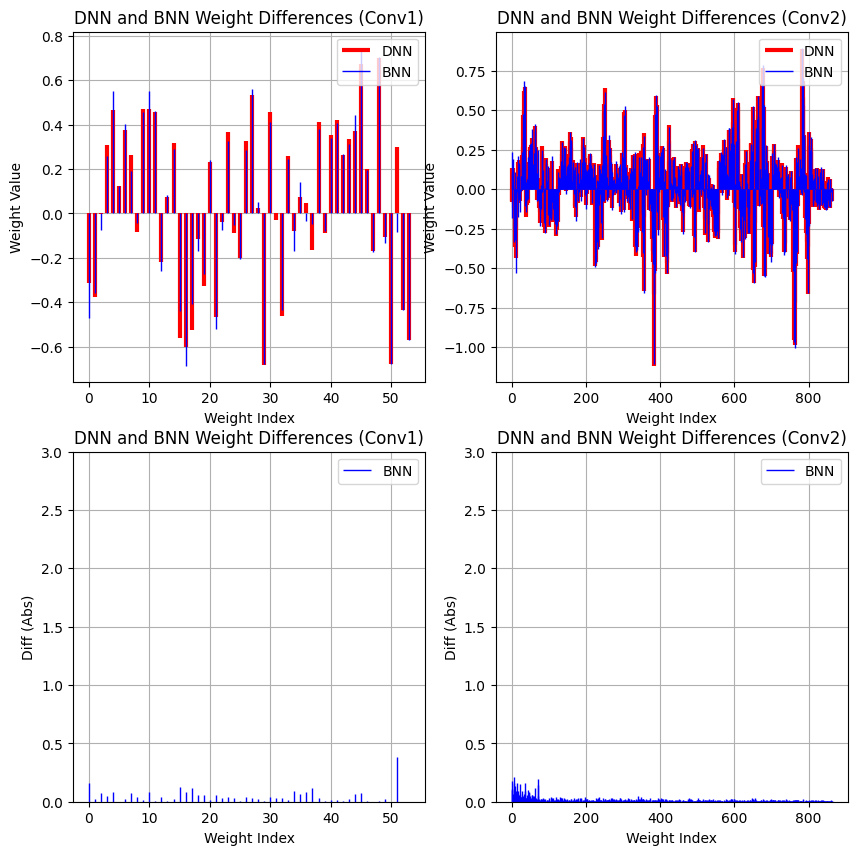

In [4]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() +  epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    bnn_multi.conv2.get_covariance_matrix() +  epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



In [5]:
import torch

if torch.any(torch.isnan(mu_flat_conv2)) or torch.any(torch.isinf(mu_flat_conv2)):
    raise ValueError("mu_flat tensor contains NaN or Inf values")

if torch.any(torch.isnan(cov_2)) or torch.any(torch.isinf(cov_2)):
    raise ValueError("covariance matrix contains NaN or Inf values")


In [6]:
mu_flat_conv2.shape

torch.Size([864])

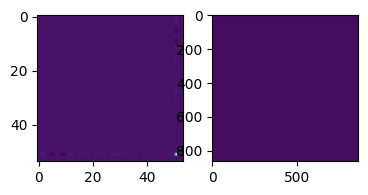

In [7]:

bnn_with_good_prior = LeNet_BNN().to(device) 

'''
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
'''
epslion = 1e-6

bnn_with_good_prior.conv1.prior_mean = bnn_multi.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_multi.conv1.get_covariance_matrix().detach().clone() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)

bnn_with_good_prior.conv2.prior_mean = bnn_multi.conv2.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv2.prior_variance = bnn_multi.conv2.get_covariance_matrix().detach().clone() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)

bnn_with_good_prior.conv1.mu_kernel = bnn_multi.conv1.mu_kernel
# bnn_with_good_prior.conv1.L_param = bnn_multi.conv1.L_param

bnn_with_good_prior.conv2.mu_kernel = bnn_multi.conv2.mu_kernel
# bnn_with_good_prior.conv2.L_param = bnn_multi.conv2.L_param

bnn_with_good_prior.fc1 = dnn.fc1

plt.subplot(1,3,1)
plt.imshow(bnn_with_good_prior.conv1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bnn_with_good_prior.conv2.prior_variance.cpu().detach().numpy())

# plt.subplot(1,3,3)
# plt.imshow(bnn_with_good_prior.fc1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

In [8]:

class args:
    pass
args = args()
args.t = 1.0
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f'runs/bnn_with_good_prior_multi')
train_BNN(epoch= 100, model = bnn_with_good_prior.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_with_good_prior.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=False)


[Train] Epoch: 0/100, Acc: 0.77680, NNL: 1.58277 KL: 21679.51327: : 59it [01:53,  1.92s/it]


[Test] Acc: 0.91560, NNL: 0.36475, KL: 6181.11035
Best model saved at epoch 0


[Train] Epoch: 1/100, Acc: 0.92463, NNL: 0.29301 KL: 3759.80858: : 59it [01:52,  1.90s/it]


[Test] Acc: 0.91560, NNL: 0.33654, KL: 2361.58521
Best model saved at epoch 1


[Train] Epoch: 2/100, Acc: 0.94665, NNL: 0.18841 KL: 1813.23185: : 59it [01:53,  1.93s/it]


[Test] Acc: 0.94430, NNL: 0.22208, KL: 1400.84937
Best model saved at epoch 2


[Train] Epoch: 3/100, Acc: 0.95763, NNL: 0.14214 KL: 1165.32894: : 59it [01:52,  1.90s/it]


[Test] Acc: 0.96870, NNL: 0.11852, KL: 968.46216
Best model saved at epoch 3


[Train] Epoch: 4/100, Acc: 0.96567, NNL: 0.11291 KL: 837.59309: : 59it [01:49,  1.85s/it]


[Test] Acc: 0.96400, NNL: 0.12917, KL: 722.56641
Best model saved at epoch 4


[Train] Epoch: 5/100, Acc: 0.96787, NNL: 0.10671 KL: 639.87646: : 59it [01:49,  1.86s/it]


[Test] Acc: 0.96820, NNL: 0.11442, KL: 565.02911
Best model saved at epoch 5


[Train] Epoch: 6/100, Acc: 0.97173, NNL: 0.09211 KL: 508.53697: : 59it [01:48,  1.84s/it]


[Test] Acc: 0.97020, NNL: 0.09802, KL: 456.38708
Best model saved at epoch 6


[Train] Epoch: 7/100, Acc: 0.97215, NNL: 0.08928 KL: 415.67010: : 59it [01:49,  1.85s/it]


[Test] Acc: 0.97190, NNL: 0.09505, KL: 377.54068
Best model saved at epoch 7


[Train] Epoch: 8/100, Acc: 0.97450, NNL: 0.08344 KL: 347.00950: : 59it [01:49,  1.85s/it]


[Test] Acc: 0.97610, NNL: 0.08295, KL: 318.10342
Best model saved at epoch 8


[Train] Epoch: 9/100, Acc: 0.97572, NNL: 0.07754 KL: 294.49726: : 59it [01:48,  1.85s/it]


[Test] Acc: 0.97310, NNL: 0.08742, KL: 271.95206
Best model saved at epoch 9


[Train] Epoch: 10/100, Acc: 0.97738, NNL: 0.07296 KL: 253.24776: : 59it [01:49,  1.86s/it]


[Test] Acc: 0.97710, NNL: 0.07281, KL: 235.25726
Best model saved at epoch 10


[Train] Epoch: 11/100, Acc: 0.97733, NNL: 0.07159 KL: 220.13733: : 59it [01:48,  1.85s/it]


[Test] Acc: 0.97210, NNL: 0.08930, KL: 205.50871
Best model saved at epoch 11


[Train] Epoch: 12/100, Acc: 0.97982, NNL: 0.06453 KL: 193.08087: : 59it [01:48,  1.85s/it]


[Test] Acc: 0.97930, NNL: 0.06826, KL: 180.99820
Best model saved at epoch 12


[Train] Epoch: 13/100, Acc: 0.98043, NNL: 0.06303 KL: 170.63968: : 59it [01:48,  1.84s/it]


[Test] Acc: 0.97690, NNL: 0.07520, KL: 160.52643
Best model saved at epoch 13


[Train] Epoch: 14/100, Acc: 0.98207, NNL: 0.05818 KL: 151.78848: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.97920, NNL: 0.06791, KL: 143.22716
Best model saved at epoch 14


[Train] Epoch: 15/100, Acc: 0.98197, NNL: 0.05654 KL: 135.78114: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.97830, NNL: 0.06655, KL: 128.46277
Best model saved at epoch 15


[Train] Epoch: 16/100, Acc: 0.98398, NNL: 0.05299 KL: 122.06046: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98180, NNL: 0.06251, KL: 115.75116
Best model saved at epoch 16


[Train] Epoch: 17/100, Acc: 0.98377, NNL: 0.05212 KL: 110.20356: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98140, NNL: 0.05795, KL: 104.72335
Best model saved at epoch 17


[Train] Epoch: 18/100, Acc: 0.98460, NNL: 0.05103 KL: 99.88299: : 59it [01:47,  1.82s/it] 


[Test] Acc: 0.97850, NNL: 0.06585, KL: 95.09146
Best model saved at epoch 18


[Train] Epoch: 19/100, Acc: 0.98417, NNL: 0.04950 KL: 90.84243: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98130, NNL: 0.06002, KL: 86.62811
Best model saved at epoch 19


[Train] Epoch: 20/100, Acc: 0.98587, NNL: 0.04640 KL: 82.87748: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98090, NNL: 0.05745, KL: 79.15147
Best model saved at epoch 20


[Train] Epoch: 21/100, Acc: 0.98548, NNL: 0.04733 KL: 75.82461: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98310, NNL: 0.05475, KL: 72.51453
Best model saved at epoch 21


[Train] Epoch: 22/100, Acc: 0.98618, NNL: 0.04587 KL: 69.54999: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98340, NNL: 0.05234, KL: 66.59644
Best model saved at epoch 22


[Train] Epoch: 23/100, Acc: 0.98680, NNL: 0.04471 KL: 63.94434: : 59it [01:47,  1.83s/it]


[Test] Acc: 0.98190, NNL: 0.05433, KL: 61.29844
Best model saved at epoch 23


[Train] Epoch: 24/100, Acc: 0.98625, NNL: 0.04529 KL: 58.91715: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98180, NNL: 0.05983, KL: 56.53864
Best model saved at epoch 24


[Train] Epoch: 25/100, Acc: 0.98627, NNL: 0.04422 KL: 54.39287: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98180, NNL: 0.05739, KL: 52.24718
Best model saved at epoch 25


[Train] Epoch: 26/100, Acc: 0.98680, NNL: 0.04387 KL: 50.30786: : 59it [01:46,  1.81s/it]


[Test] Acc: 0.98360, NNL: 0.05291, KL: 48.36681
Best model saved at epoch 26


[Train] Epoch: 27/100, Acc: 0.98677, NNL: 0.04307 KL: 46.60888: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98320, NNL: 0.05317, KL: 44.84790
Best model saved at epoch 27


[Train] Epoch: 28/100, Acc: 0.98655, NNL: 0.04305 KL: 43.25031: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98310, NNL: 0.05063, KL: 41.64848
Best model saved at epoch 28


[Train] Epoch: 29/100, Acc: 0.98822, NNL: 0.04005 KL: 40.19268: : 59it [01:46,  1.81s/it]


[Test] Acc: 0.98450, NNL: 0.05223, KL: 38.73199
Best model saved at epoch 29


[Train] Epoch: 30/100, Acc: 0.98750, NNL: 0.04009 KL: 37.40293: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98280, NNL: 0.05604, KL: 36.06850
Best model saved at epoch 30


[Train] Epoch: 31/100, Acc: 0.98803, NNL: 0.03996 KL: 34.85230: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98460, NNL: 0.04968, KL: 33.63033
Best model saved at epoch 31


[Train] Epoch: 32/100, Acc: 0.98828, NNL: 0.03932 KL: 32.51521: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98400, NNL: 0.05237, KL: 31.39417
Best model saved at epoch 32


[Train] Epoch: 33/100, Acc: 0.98752, NNL: 0.04048 KL: 30.37026: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98370, NNL: 0.04982, KL: 29.33996
Best model saved at epoch 33


[Train] Epoch: 34/100, Acc: 0.98797, NNL: 0.03844 KL: 28.39774: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98400, NNL: 0.04982, KL: 27.44948
Best model saved at epoch 34


[Train] Epoch: 35/100, Acc: 0.98883, NNL: 0.03724 KL: 26.58159: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98430, NNL: 0.05013, KL: 25.70738
Best model saved at epoch 35


[Train] Epoch: 36/100, Acc: 0.98918, NNL: 0.03723 KL: 24.90646: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98390, NNL: 0.05169, KL: 24.09939
Best model saved at epoch 36


[Train] Epoch: 37/100, Acc: 0.98867, NNL: 0.03821 KL: 23.35952: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98400, NNL: 0.05115, KL: 22.61374
Best model saved at epoch 37


[Train] Epoch: 38/100, Acc: 0.98945, NNL: 0.03695 KL: 21.92922: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98300, NNL: 0.04959, KL: 21.23899
Best model saved at epoch 38


[Train] Epoch: 39/100, Acc: 0.98913, NNL: 0.03613 KL: 20.60507: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98430, NNL: 0.04986, KL: 19.96559
Best model saved at epoch 39


[Train] Epoch: 40/100, Acc: 0.98917, NNL: 0.03625 KL: 19.37804: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98440, NNL: 0.05016, KL: 18.78519
Best model saved at epoch 40


[Train] Epoch: 41/100, Acc: 0.98947, NNL: 0.03634 KL: 18.23991: : 59it [01:47,  1.83s/it]


[Test] Acc: 0.98440, NNL: 0.04762, KL: 17.68953
Best model saved at epoch 41


[Train] Epoch: 42/100, Acc: 0.98893, NNL: 0.03626 KL: 17.18313: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98430, NNL: 0.04883, KL: 16.67229
Best model saved at epoch 42


[Train] Epoch: 43/100, Acc: 0.98962, NNL: 0.03537 KL: 16.20125: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98540, NNL: 0.04951, KL: 15.72588
Best model saved at epoch 43


[Train] Epoch: 44/100, Acc: 0.98983, NNL: 0.03449 KL: 15.28810: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98500, NNL: 0.04643, KL: 14.84620
Best model saved at epoch 44


[Train] Epoch: 45/100, Acc: 0.98962, NNL: 0.03511 KL: 14.43863: : 59it [01:47,  1.83s/it]


[Test] Acc: 0.98520, NNL: 0.04645, KL: 14.02722
Best model saved at epoch 45


[Train] Epoch: 46/100, Acc: 0.98945, NNL: 0.03458 KL: 13.64753: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98490, NNL: 0.04747, KL: 13.26441
Best model saved at epoch 46


[Train] Epoch: 47/100, Acc: 0.99003, NNL: 0.03379 KL: 12.91071: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98460, NNL: 0.04821, KL: 12.55342
Best model saved at epoch 47


[Train] Epoch: 48/100, Acc: 0.99048, NNL: 0.03305 KL: 12.22389: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98500, NNL: 0.04831, KL: 11.89087
Best model saved at epoch 48


[Train] Epoch: 49/100, Acc: 0.99038, NNL: 0.03335 KL: 11.58372: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98570, NNL: 0.04716, KL: 11.27315
Best model saved at epoch 49


[Train] Epoch: 50/100, Acc: 0.99002, NNL: 0.03367 KL: 10.98660: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98450, NNL: 0.04891, KL: 10.69690
Best model saved at epoch 50


[Train] Epoch: 51/100, Acc: 0.99028, NNL: 0.03286 KL: 10.42955: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98550, NNL: 0.04590, KL: 10.15941
Best model saved at epoch 51


[Train] Epoch: 52/100, Acc: 0.99063, NNL: 0.03241 KL: 9.90978: : 59it [01:47,  1.82s/it] 


[Test] Acc: 0.98470, NNL: 0.04759, KL: 9.65744
Best model saved at epoch 52


[Train] Epoch: 53/100, Acc: 0.99073, NNL: 0.03209 KL: 9.42458: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98590, NNL: 0.04556, KL: 9.18948
Best model saved at epoch 53


[Train] Epoch: 54/100, Acc: 0.99043, NNL: 0.03251 KL: 8.97192: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98560, NNL: 0.04747, KL: 8.75214
Best model saved at epoch 54


[Train] Epoch: 55/100, Acc: 0.99068, NNL: 0.03178 KL: 8.54921: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98480, NNL: 0.04776, KL: 8.34415
Best model saved at epoch 55


[Train] Epoch: 56/100, Acc: 0.99063, NNL: 0.03179 KL: 8.15481: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98590, NNL: 0.04454, KL: 7.96353
Best model saved at epoch 56


[Train] Epoch: 57/100, Acc: 0.99052, NNL: 0.03150 KL: 7.78658: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98580, NNL: 0.04745, KL: 7.60777
Best model saved at epoch 57


[Train] Epoch: 58/100, Acc: 0.99077, NNL: 0.03165 KL: 7.44296: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98510, NNL: 0.04670, KL: 7.27631
Best model saved at epoch 58


[Train] Epoch: 59/100, Acc: 0.99112, NNL: 0.03090 KL: 7.12229: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98550, NNL: 0.04675, KL: 6.96662
Best model saved at epoch 59


[Train] Epoch: 60/100, Acc: 0.99108, NNL: 0.03084 KL: 6.82327: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98480, NNL: 0.04625, KL: 6.67805
Best model saved at epoch 60


[Train] Epoch: 61/100, Acc: 0.99025, NNL: 0.03114 KL: 6.54426: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98530, NNL: 0.04658, KL: 6.40882
Best model saved at epoch 61


[Train] Epoch: 62/100, Acc: 0.99125, NNL: 0.03059 KL: 6.28419: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98500, NNL: 0.04804, KL: 6.15826
Best model saved at epoch 62


[Train] Epoch: 63/100, Acc: 0.99098, NNL: 0.03020 KL: 6.04178: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98430, NNL: 0.04753, KL: 5.92420
Best model saved at epoch 63


[Train] Epoch: 64/100, Acc: 0.99112, NNL: 0.03010 KL: 5.81604: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98480, NNL: 0.04846, KL: 5.70662
Best model saved at epoch 64


[Train] Epoch: 65/100, Acc: 0.99118, NNL: 0.02993 KL: 5.60574: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98540, NNL: 0.04626, KL: 5.50377
Best model saved at epoch 65


[Train] Epoch: 66/100, Acc: 0.99117, NNL: 0.02991 KL: 5.41013: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98540, NNL: 0.04447, KL: 5.31536
Best model saved at epoch 66


[Train] Epoch: 67/100, Acc: 0.99108, NNL: 0.02977 KL: 5.22810: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98540, NNL: 0.04685, KL: 5.14024
Best model saved at epoch 67


[Train] Epoch: 68/100, Acc: 0.99140, NNL: 0.02884 KL: 5.05895: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98520, NNL: 0.04610, KL: 4.97709
Best model saved at epoch 68


[Train] Epoch: 69/100, Acc: 0.99158, NNL: 0.02872 KL: 4.90186: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98600, NNL: 0.04487, KL: 4.82584
Best model saved at epoch 69


[Train] Epoch: 70/100, Acc: 0.99157, NNL: 0.02880 KL: 4.75607: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98540, NNL: 0.04687, KL: 4.68550
Best model saved at epoch 70


[Train] Epoch: 71/100, Acc: 0.99190, NNL: 0.02797 KL: 4.62084: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98500, NNL: 0.04534, KL: 4.55552
Best model saved at epoch 71


[Train] Epoch: 72/100, Acc: 0.99162, NNL: 0.02848 KL: 4.49561: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98500, NNL: 0.04634, KL: 4.43520
Best model saved at epoch 72


[Train] Epoch: 73/100, Acc: 0.99182, NNL: 0.02761 KL: 4.37962: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98560, NNL: 0.04596, KL: 4.32387
Best model saved at epoch 73


[Train] Epoch: 74/100, Acc: 0.99200, NNL: 0.02774 KL: 4.27242: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98460, NNL: 0.04880, KL: 4.22070
Best model saved at epoch 74


[Train] Epoch: 75/100, Acc: 0.99192, NNL: 0.02762 KL: 4.17335: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98510, NNL: 0.04729, KL: 4.12554
Best model saved at epoch 75


[Train] Epoch: 76/100, Acc: 0.99248, NNL: 0.02719 KL: 4.08185: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98540, NNL: 0.04673, KL: 4.03810
Best model saved at epoch 76


[Train] Epoch: 77/100, Acc: 0.99200, NNL: 0.02718 KL: 3.99775: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98520, NNL: 0.04840, KL: 3.95709
Best model saved at epoch 77


[Train] Epoch: 78/100, Acc: 0.99237, NNL: 0.02697 KL: 3.92018: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98590, NNL: 0.04592, KL: 3.88290
Best model saved at epoch 78


[Train] Epoch: 79/100, Acc: 0.99170, NNL: 0.02740 KL: 3.84888: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98570, NNL: 0.04728, KL: 3.81476
Best model saved at epoch 79


[Train] Epoch: 80/100, Acc: 0.99218, NNL: 0.02702 KL: 3.78351: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98600, NNL: 0.04441, KL: 3.75199
Best model saved at epoch 80


[Train] Epoch: 81/100, Acc: 0.99208, NNL: 0.02702 KL: 3.72354: : 59it [01:46,  1.81s/it]


[Test] Acc: 0.98520, NNL: 0.04670, KL: 3.69463
Best model saved at epoch 81


[Train] Epoch: 82/100, Acc: 0.99248, NNL: 0.02600 KL: 3.66849: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98560, NNL: 0.04573, KL: 3.64212
Best model saved at epoch 82


[Train] Epoch: 83/100, Acc: 0.99248, NNL: 0.02593 KL: 3.61836: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98510, NNL: 0.04615, KL: 3.59433
Best model saved at epoch 83


[Train] Epoch: 84/100, Acc: 0.99255, NNL: 0.02618 KL: 3.57258: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98580, NNL: 0.04518, KL: 3.55071
Best model saved at epoch 84


[Train] Epoch: 85/100, Acc: 0.99273, NNL: 0.02577 KL: 3.53083: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98560, NNL: 0.04553, KL: 3.51086
Best model saved at epoch 85


[Train] Epoch: 86/100, Acc: 0.99248, NNL: 0.02572 KL: 3.49289: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98490, NNL: 0.04648, KL: 3.47494
Best model saved at epoch 86


[Train] Epoch: 87/100, Acc: 0.99243, NNL: 0.02582 KL: 3.45847: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98480, NNL: 0.04802, KL: 3.44214
Best model saved at epoch 87


[Train] Epoch: 88/100, Acc: 0.99267, NNL: 0.02496 KL: 3.42721: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98450, NNL: 0.04592, KL: 3.41256
Best model saved at epoch 88


[Train] Epoch: 89/100, Acc: 0.99275, NNL: 0.02527 KL: 3.39907: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98490, NNL: 0.04776, KL: 3.38590
Best model saved at epoch 89


[Train] Epoch: 90/100, Acc: 0.99292, NNL: 0.02452 KL: 3.37346: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98480, NNL: 0.04880, KL: 3.36141
Best model saved at epoch 90


[Train] Epoch: 91/100, Acc: 0.99250, NNL: 0.02514 KL: 3.35063: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98620, NNL: 0.04509, KL: 3.33966
Best model saved at epoch 91


[Train] Epoch: 92/100, Acc: 0.99268, NNL: 0.02563 KL: 3.32999: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98580, NNL: 0.04596, KL: 3.32058
Best model saved at epoch 92


[Train] Epoch: 93/100, Acc: 0.99280, NNL: 0.02473 KL: 3.31143: : 59it [01:47,  1.83s/it]


[Test] Acc: 0.98480, NNL: 0.05048, KL: 3.30266
Best model saved at epoch 93


[Train] Epoch: 94/100, Acc: 0.99262, NNL: 0.02512 KL: 3.29488: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98490, NNL: 0.04875, KL: 3.28698
Best model saved at epoch 94


[Train] Epoch: 95/100, Acc: 0.99280, NNL: 0.02453 KL: 3.28007: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98540, NNL: 0.04546, KL: 3.27287
Best model saved at epoch 95


[Train] Epoch: 96/100, Acc: 0.99320, NNL: 0.02391 KL: 3.26671: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98530, NNL: 0.04676, KL: 3.26044
Best model saved at epoch 96


[Train] Epoch: 97/100, Acc: 0.99323, NNL: 0.02360 KL: 3.25491: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98520, NNL: 0.04884, KL: 3.24937
Best model saved at epoch 97


[Train] Epoch: 98/100, Acc: 0.99308, NNL: 0.02393 KL: 3.24459: : 59it [01:47,  1.82s/it]


[Test] Acc: 0.98560, NNL: 0.04645, KL: 3.23956
Best model saved at epoch 98


[Train] Epoch: 99/100, Acc: 0.99275, NNL: 0.02407 KL: 3.23536: : 59it [01:47,  1.83s/it]


[Test] Acc: 0.98550, NNL: 0.04658, KL: 3.23085
Best model saved at epoch 99


### mu_kernel 복사, Prior 설정 -> 즉, Cov 학습한것을 Prior로 설정한것을 제외하고 동일함 (24.7.13)
### 결과 -> 매우 좋은 성능을 보임

### Cov = I

10000it [00:46, 215.52it/s]


Text(0.5, 1.0, 'Loss')

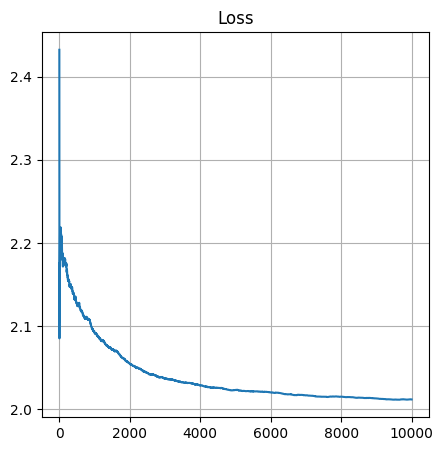

In [20]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_flat_conv1.mean().item() + mu_flat_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


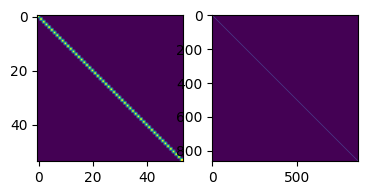

In [21]:

bnn_with_good_prior = LeNet_BNN().to(device) 

'''
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
'''
epslion = 1e-6

bnn_with_good_prior.conv1.prior_mean = bnn_multi.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)

bnn_with_good_prior.conv2.prior_mean = bnn_multi.conv2.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv2.prior_variance = torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)

bnn_with_good_prior.conv1.mu_kernel = bnn_multi.conv1.mu_kernel
# bnn_with_good_prior.conv1.L_param = bnn_multi.conv1.L_param

bnn_with_good_prior.conv2.mu_kernel = bnn_multi.conv2.mu_kernel
# bnn_with_good_prior.conv2.L_param = bnn_multi.conv2.L_param

bnn_with_good_prior.fc1 = dnn.fc1

plt.subplot(1,3,1)
plt.imshow(bnn_with_good_prior.conv1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bnn_with_good_prior.conv2.prior_variance.cpu().detach().numpy())

# plt.subplot(1,3,3)
# plt.imshow(bnn_with_good_prior.fc1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

In [22]:

class args:
    pass
args = args()
args.t = 1.0
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f'runs/bnn_with_covI_multi')
train_BNN(epoch= 100, model = bnn_with_good_prior.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_with_good_prior.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=False)


[Train] Epoch: 0/100, Acc: 0.81465, NNL: 0.94031 KL: 0.45748: : 34it [01:03,  1.88s/it]


KeyboardInterrupt: 

### Randomly Initialized Cov

10000it [00:53, 187.31it/s]


Text(0.5, 1.0, 'Loss')

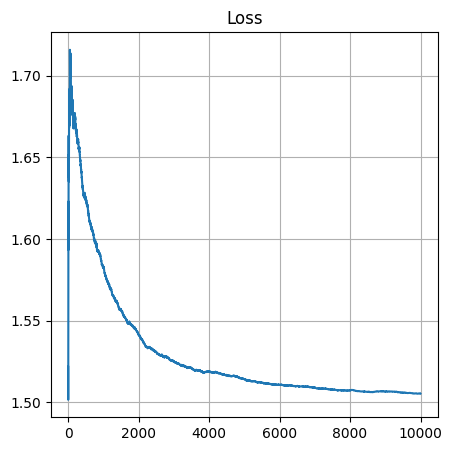

In [23]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv2.mu_kernel], lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix()
    cov_2 = bnn_multi.conv2.get_covariance_matrix()
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_bnn_conv1.mean().item() + mu_bnn_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


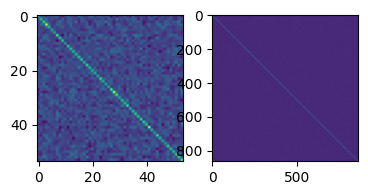

In [24]:

bnn_with_good_prior = LeNet_BNN().to(device) 

'''
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
'''
epslion = 1e-6

bnn_with_good_prior.conv1.prior_mean = bnn_multi.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_multi.conv1.get_covariance_matrix().detach().clone()

bnn_with_good_prior.conv2.prior_mean = bnn_multi.conv2.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv2.prior_variance = bnn_multi.conv2.get_covariance_matrix().detach().clone()

bnn_with_good_prior.conv1.mu_kernel = bnn_multi.conv1.mu_kernel
# bnn_with_good_prior.conv1.L_param = bnn_multi.conv1.L_param

bnn_with_good_prior.conv2.mu_kernel = bnn_multi.conv2.mu_kernel
# bnn_with_good_prior.conv2.L_param = bnn_multi.conv2.L_param

bnn_with_good_prior.fc1 = dnn.fc1

plt.subplot(1,3,1)
plt.imshow(bnn_with_good_prior.conv1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bnn_with_good_prior.conv2.prior_variance.cpu().detach().numpy())

# plt.subplot(1,3,3)
# plt.imshow(bnn_with_good_prior.fc1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

In [25]:

class args:
    pass
args = args()
args.t = 1.0
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f'runs/bnn_with_cov_random_multi')
train_BNN(epoch= 100, model = bnn_with_good_prior.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_with_good_prior.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=False)


[Train] Epoch: 0/100, Acc: 0.89338, NNL: 0.47514 KL: 43.98667: : 59it [02:12,  2.25s/it] 


[Test] Acc: 0.94400, NNL: 0.22786, KL: 8.48806
Best model saved at epoch 0


[Train] Epoch: 1/100, Acc: 0.94522, NNL: 0.19714 KL: 6.17330: : 59it [01:52,  1.91s/it]


[Test] Acc: 0.94620, NNL: 0.20490, KL: 4.65600
Best model saved at epoch 1


[Train] Epoch: 2/100, Acc: 0.95285, NNL: 0.16324 KL: 3.88168: : 59it [01:52,  1.91s/it]


[Test] Acc: 0.96130, NNL: 0.13205, KL: 3.24728
Best model saved at epoch 2


[Train] Epoch: 3/100, Acc: 0.96108, NNL: 0.12006 KL: 3.14280: : 14it [00:26,  1.88s/it]

In [ ]:
# Sample the weights

# loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv1.L_param, bnn_multi.conv1.B_param], lr=1e-3)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in range(1000):
    
    mu = bnn_multi.conv1.mu_kernel
    sigma = bnn_multi.conv1.get_covariance_matrix(bnn_multi.conv1.L_param, bnn_multi.conv1.B_param)

    k = 
    loss_val = 0.5 * (k * torch.log(2 * torch.pi) + torch.log(cov_det) + mahalanobis_dist)
    # loss_val = 0.5 * torch.mean((mu - w_conv1_dnn)**2 / sigma + sigma )
        
        
    
    # loss_val = loss(w, w_conv1_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = bnn_uni.conv1.mu_kernel  # 실제 mu_kernel 값으로 대체
rho_kernel = bnn_uni.conv1.rho_kernel  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv1.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(6,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            

In [ ]:
from bayesian_torch.layers.variational_layers.conv_variational_layers import Conv2dReparameterization_Multivariate

# Hook 함수 정의
def hook_fn(module, input, output):
    if isinstance(module, Conv2dReparameterization_Multivariate):
        if module == bnn.conv1:
            bnn_conv1_out.append(output)
        elif module == bnn.conv2:
            bnn_conv2_out.append(output)
    # elif isinstance(module, nn.AvgPool2d):
    #     bnn_pool_out.append(output)


# 모델 초기화
# dnn = LeNet()
bnn = LeNet_BNN()  # 실제로는 Bayesian Neural Network여야 함

# Hook을 저장할 리스트
dnn_conv1_out = []
dnn_conv2_out = []
dnn_pool_out = []
bnn_conv1_out = []
bnn_conv2_out = []
bnn_pool_out = []

# Hook 등록
dnn.conv1.register_forward_hook(lambda m, i, o: dnn_conv1_out.append(o))
dnn.conv2.register_forward_hook(lambda m, i, o: dnn_conv2_out.append(o))
dnn.pool.register_forward_hook(lambda m, i, o: dnn_pool_out.append(o))

bnn.conv1.register_forward_hook(hook_fn)
bnn.conv2.register_forward_hook(hook_fn)
bnn.pool.register_forward_hook(hook_fn)

# 옵티마이저 설정
optimizer = torch.optim.Adam(bnn.parameters(), lr=1e-3)#, momentum=0.9, nesterov=True)

# Knowledge Distillation 학습 루프
epochs = 10
for e in range(epochs):
    pbar = tqdm(enumerate(train_loader))
    dnn.eval().cuda()
    bnn.train().cuda()
    
    losses = []
    for batch_idx, (data, target) in pbar:
        data, target = data.cuda(), target.cuda()
        
        with torch.no_grad():
            dnn_conv1_out.clear()
            dnn_conv2_out.clear()
            dnn_pool_out.clear()
            
            y_t = dnn(data)
            # output_t = [dnn_conv1_out[0], dnn_conv2_out[0], y_t]
            output_t = [dnn_conv1_out[0]]
            
        bnn_conv1_out.clear()
        bnn_conv2_out.clear()
        bnn_pool_out.clear()
        
        y_s, _ = bnn(data)
        # output_s = [bnn_conv1_out[0][0], bnn_conv2_out[0][0], y_s]
        output_s = [bnn_conv1_out[0][0]]
        
        loss = 0
        for idx, (t, s) in enumerate(zip(output_t, output_s)):
            loss += F.mse_loss(s, t)
        
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"Loss: {np.mean(losses):.3f} Epoch: {e}")


In [ ]:
# Visualize the covariance matrix

import matplotlib.pyplot as plt
conv1_cov = bnn.conv1.get_covariance_matrix(bnn.conv1.L_param, bnn.conv1.B_param).cpu().detach().numpy()
# conv2_cov = bnn.conv2.get_covariance_matrix(bnn.conv2.L_param, bnn.conv2.B_param).cpu().detach().numpy()

In [ ]:
i=1
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(conv1_cov[:9*i,:9*i], cmap='plasma')

i=9
plt.subplot(1,2,2)
plt.imshow(conv1_cov[:9*i,:9*i], cmap='plasma')

In [ ]:

bnn_with_good_prior = LeNet_BNN()
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

# bnn_with_good_prior.conv2.prior_mean = bnn.conv2.mu_kernel.detach().clone().flatten()
# bnn_with_good_prior.conv2.prior_variance = bnn_with_good_prior.conv2.get_covariance_matrix(bnn.conv2.L_param.detach().clone(), bnn.conv2.B_param.detach().clone())

train_BNN(10, bnn_with_good_prior)


In [ ]:
# Visualize the covariance matrix
import matplotlib.pyplot as plt
conv1_cov = naiive_bnn.conv1.get_covariance_matrix(naiive_bnn.conv1.L_param, naiive_bnn.conv1.B_param).cpu().detach().numpy()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(conv1_cov[:,:], cmap='plasma')

conv1_cov2 = bnn_with_good_prior.conv1.get_covariance_matrix(bnn_with_good_prior.conv1.L_param, bnn_with_good_prior.conv1.B_param).cpu().detach().numpy()
plt.subplot(1,2,2)
plt.imshow(conv1_cov2[:,:], cmap='plasma')